# Install Required Libraries

In [158]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.3.0
appnope                      0.1.4
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.15.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.3
certifi                      2023.5.7
cffi                         1.16.0
charset-normalizer           3.1.0
click                        8.1.3
comm                         0.2.2
contourpy                    1.0.7
curve                        0.0.7
cycler                       0.11.0
debugpy                      1.8.1
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.2.1

In [159]:
!pip install opencv-python matplotlib imageio gdown tensorflow==2.10.1

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import gdown
import tensorflow as tf
from typing import List

2024-05-27 12:17:49.704096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#tf.config.list_physical_devices('GPU')

In [3]:
'''
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
    '''

"\nphysical_devices = tf.config.list_physical_devices('GPU')\ntry:\n    tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n    pass\n    "

In [4]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=d1c20602-2fee-41e9-94b4-a251c13e96af
To: /Users/wuhaoming/Documents/GitHub/LIp-Reading-App/data.zip
100%|██████████| 423M/423M [00:15<00:00, 27.0MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

# Create Data Loading Functions

In [2]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        #only take the mouth region, could be improved by using a face detector
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    #normalize the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [4]:
# char to num and num to char mappings
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

2024-05-27 12:18:08.543275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [6]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [7]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [8]:
test_path = './data/s1/bbal6n.mpg'

In [9]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [10]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

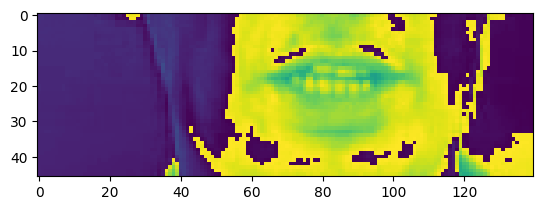

In [11]:
plt.imshow(frames[40])

In [12]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [13]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [14]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Create Data Pipeline

In [15]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [16]:
len(test)

50

In [17]:
frames, alignments = data.as_numpy_iterator().next()

In [18]:
len(frames)

2

In [19]:
val = data.as_numpy_iterator().next()

In [20]:
val[0]

array([[[[[1.4448025 ],
          [1.4448025 ],
          [1.4086825 ],
          ...,
          [0.36120063],
          [0.28896052],
          [0.28896052]],

         [[1.4448025 ],
          [1.4448025 ],
          [1.4086825 ],
          ...,
          [0.36120063],
          [0.28896052],
          [0.28896052]],

         [[1.4809226 ],
          [1.4809226 ],
          [1.4448025 ],
          ...,
          [0.3973207 ],
          [0.32508057],
          [0.32508057]],

         ...,

         [[0.9752417 ],
          [0.9752417 ],
          [0.9752417 ],
          ...,
          [0.07224013],
          [0.07224013],
          [0.07224013]],

         [[0.9752417 ],
          [0.9752417 ],
          [0.9752417 ],
          ...,
          [0.03612006],
          [0.03612006],
          [0.03612006]],

         [[0.9752417 ],
          [0.9752417 ],
          [0.9752417 ],
          ...,
          [0.03612006],
          [0.03612006],
          [0.03612006]]],


        [[[1.4448

In [21]:
val[0][0].shape

(75, 46, 140, 1)

In [22]:
processed_frames = [(frame.squeeze(axis=-1)).astype(np.uint8) for frame in val[0][0]]

In [23]:
imageio.mimsave('./animation.gif', processed_frames, fps=10)

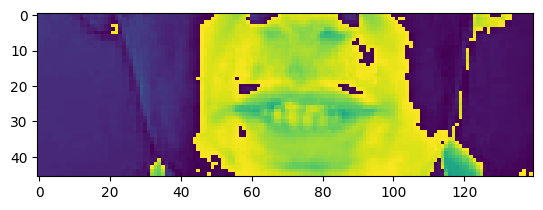

In [24]:
plt.imshow(val[0][0][35])

In [25]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white in m seven again'>

# Design the Deep Neural Network

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [27]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [30]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [31]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwbwwwwwwwwwwwwwwwwwwwwwwwwwwwwb6'>

In [32]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwbwwwwwwwwwwwwwwwwwwwwwwwwwwwwb6'>

In [33]:
model.input_shape

(None, 75, 46, 140, 1)

In [34]:
model.output_shape

(None, 75, 41)

# Set Training Options and Train the Model

In [35]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [36]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [37]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self,dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self,epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for i in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][i])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[i])).numpy().decode('utf-8'))
            print('~'*100)

In [38]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [40]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor = 'loss', save_weights_only=True)

In [41]:
schedule_callback = LearningRateScheduler(scheduler)

In [42]:
example_callback = ProduceExample(data)

In [43]:
model.fit(train, validation_data = test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  1/450 [..............................] - ETA: 7:14:50 - loss: 233.0831

KeyboardInterrupt: 

# Make Prediction

In [45]:
model.load_weights('model/checkpoint')

In [48]:
test_data = data.as_numpy_iterator()

In [49]:
sample = test_data.next()

In [50]:
yhat = model.predict(sample[0])

1/1 [==============================] - 5s 5s/step


In [51]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green with z zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with l three again'>]

In [52]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [53]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green with z z zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with l three again'>]

# Test on a Video

In [54]:
sample = load_data(tf.convert_to_tensor('./data/s1/bbal6n.mpg'))

In [55]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>]

In [56]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [57]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [58]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>]